# Multinonimial Naive Bayes (MNB) Classifier

Foundations of Data Science, La Sapienza University of Rome, Autum 2024

Group 27

Team Members:
- Oskar Nesheim
- August Nyheim
- Magnus Ouren

In [18]:
import re
import time
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Constants:

In [19]:
# Constants
DATA_LOCATION = './data'
DATA_FILE = 'movies_balanced.json'
GENRES_FILE = 'popular_genres.json'

## Resources:

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/magnusouren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Data:

In [21]:
# Load dataset
data = pd.read_json(f'{DATA_LOCATION}/{DATA_FILE}')

# load genres
genres = pd.read_json(f'{DATA_LOCATION}/{GENRES_FILE}')
genres = genres.to_numpy().flatten()

## Preprocess Data:

In [22]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)

    # Tokenize text
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join words back to string
    return ' '.join(tokens)

In [23]:
data['overview'] = data['overview'].apply(preprocess_text)


## Split Data:

In [24]:
# Splitting the data into training, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    data['overview'], data['genre'], test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)


## Vectorize Data:

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=5000, sublinear_tf=True)

X_train_vectors = vectorizer.fit_transform(X_train)
X_val_vectors = vectorizer.transform(X_val)
X_test_vectors = vectorizer.transform(X_test)

## Train Model:

In [26]:
model = MultinomialNB()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(
    estimator=model,  
    param_grid={
        'alpha': param_grid['alpha'],
    },  # Parameters to tune
    cv=10,  # Folds for cross-validation
    scoring='f1_weighted',  # Scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=3  # For printing out progress
)

grid_search.fit(X_train_vectors, y_train)
best_model = grid_search.best_estimator_

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 1/10] END ......................alpha=0.001;, score=0.358 total time=   0.0s
[CV 2/10] END ......................alpha=0.001;, score=0.358 total time=   0.0s
[CV 3/10] END ......................alpha=0.001;, score=0.355 total time=   0.0s
[CV 4/10] END ......................alpha=0.001;, score=0.346 total time=   0.0s
[CV 6/10] END ......................alpha=0.001;, score=0.370 total time=   0.0s
[CV 5/10] END ......................alpha=0.001;, score=0.385 total time=   0.0s
[CV 9/10] END ......................alpha=0.001;, score=0.363 total time=   0.0s
[CV 10/10] END .....................alpha=0.001;, score=0.353 total time=   0.0s
[CV 8/10] END ......................alpha=0.001;, score=0.372 total time=   0.0s
[CV 1/10] END .......................alpha=0.01;, score=0.382 total time=   0.0s
[CV 7/10] END ......................alpha=0.001;, score=0.362 total time=   0.0s
[CV 3/10] END .......................alpha=0.01;

## Evaluate Model:

In [27]:
y_pred = best_model.predict(X_val_vectors)
y_prob = best_model.predict_proba(X_val_vectors)


## Apply test data on model:

In [28]:
y_pred = best_model.predict(X_test_vectors)

## Print results

In [29]:
print("Best Model:", best_model)
print("Accuracy:", best_model.score(X_test_vectors, y_test))
print(classification_report(y_test, y_pred))

Best Model: MultinomialNB(alpha=1)
Accuracy: 0.427
              precision    recall  f1-score   support

      Action       0.35      0.41      0.38        96
   Adventure       0.47      0.42      0.44       113
   Animation       0.48      0.51      0.50        78
      Comedy       0.36      0.35      0.35       106
       Crime       0.40      0.45      0.43        99
 Documentary       0.63      0.81      0.71        89
       Drama       0.26      0.19      0.22       100
      Horror       0.54      0.66      0.60       104
     Romance       0.36      0.37      0.36       114
    Thriller       0.29      0.17      0.21       101

    accuracy                           0.43      1000
   macro avg       0.41      0.43      0.42      1000
weighted avg       0.41      0.43      0.41      1000



### Confusion Matrix

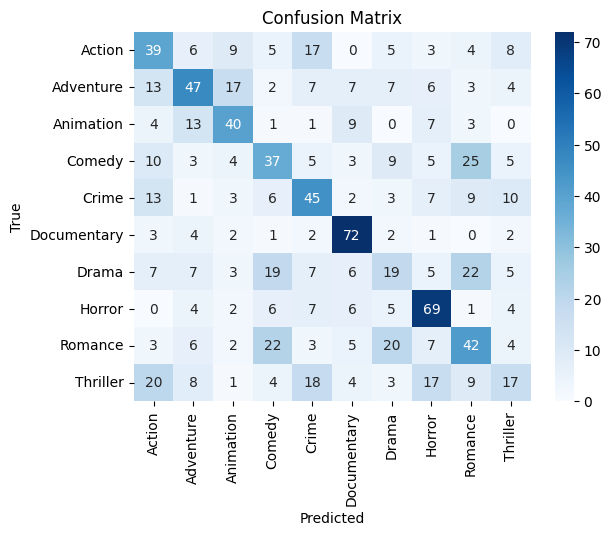

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Classification Report Chart

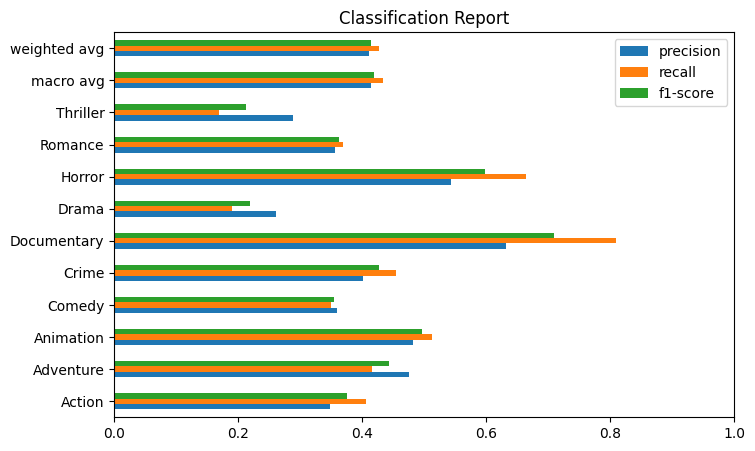

In [31]:
report = pd.DataFrame(classification_report(
    y_test, y_pred, output_dict=True)).transpose()
report.drop(['accuracy'], inplace=True)
report['support'] = report['support'].apply(int)
fig, ax = plt.subplots(figsize=(8, 5))
report[['precision', 'recall', 'f1-score']].plot(kind='barh', ax=ax)
ax.set_title('Classification Report')
ax.set_xlim([0, 1])
plt.show()

### Classification Report Table

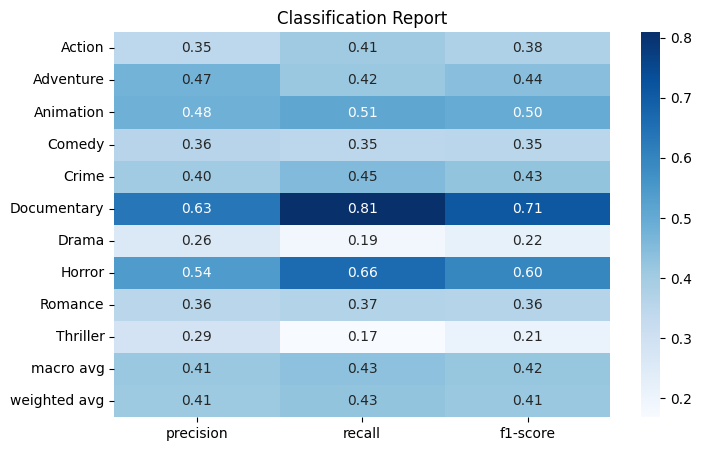

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(report[['precision', 'recall', 'f1-score']], annot=True,
            cmap='Blues', fmt=".2f", ax=ax)
ax.set_title('Classification Report')
plt.show()